# Multiorder Laplacian in random simplicial complex

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from math import factorial

import networkx as nx
import seaborn as sb

sb.set_context('paper')

from itertools import combinations, permutations

# %matplotlib tk

## Functions

### Useful simplicial complex functions

In [2]:
def num_tri(G) :
    """Returns number of triangles in networkx graph G"""
    return int(np.sum(list(nx.triangles(G).values())) / 3)


def info(G) : 
    n_tri = num_tri(G)
    n_links = len(G.edges)
    
    return f"{len(G)} nodes, {n_links} edges and {n_tri} triangles"

### Multiorder Laplacian functions

In [3]:
def adj_tensor_of_order(d, d_simplices) : 
    """Returns the adjacency tensor of order d of t"""
    
    assert len(d_simplices[0]) == d+1
    
    dims = (N,) * (d+1)
    M = np.zeros(dims)
#     print(M.shape)
    
    for d_simplex in d_simplices :
        for d_simplex_perm in permutations(d_simplex) : 
#         print(i,j,k)
#             print(d_simplex_perm)
    
            M[d_simplex_perm] = 1
    return M

def adj_matrix_of_order(d, M) : 
    
    adj_d = 1 / factorial(d-1) * np.sum(M, axis=tuple(range(d+1)[2:])) # sum over all axes except first 2 (i,j)
    
    return adj_d

def degree_of_order(d, M) : 
    
    K_d = 1 / factorial(d) * np.sum(M, axis=tuple(range(d+1)[1:])) # sum over all axes except first 2 (i,j)
    
    return K_d

def laplacian_of_order(d, d_simplices, return_k=False) :
    
    M_d = adj_tensor_of_order(d, d_simplices)
    
    Adj_d = adj_matrix_of_order(d, M_d)
    K_d = degree_of_order(d, M_d) 
    
    L_d = d * np.diag(K_d) - Adj_d
    
    if return_k :
        return L_d, K_d
    else:
        return L_d
    

### Functions to generate random simplcial complex

In [4]:
def get_p1_and_p2(k1,k2,N):
    """Returns probabilities p1 (edges) and p2 (triangles) from average degrees k1, k2 and number of nodes N
    (function from I. Iacopini et al. https://github.com/iaciac/simplagion)"""
    p2 = (2.*k2)/((N-1.)*(N-2.))
    p1 = (k1 - 2.*k2)/((N-1.)- 2.*k2)
    if (p1>=0) and (p2>=0):
        return p1, p2
    else:
        print(p1, p2)
        raise ValueError('Negative probability!')
        
def generate_random_hypergraph(p1, p2, N) : 
    """based on RSC model from https://github.com/iaciac/simplagion"""
    
    G = nx.random_graphs.erdos_renyi_graph(N, p1)

    # add random triangles
    triangles_list = []

    for tri in combinations(list(G.nodes()),3):
        # create the triangle with probability p2
        if random.random() <= p2:
            #I close the triangle.
            triangles_list.append(tri)

            #Now I also need to add the new links to the graph created by the triangle
            G.add_edge(tri[0], tri[1])
            G.add_edge(tri[1], tri[2])
            G.add_edge(tri[0], tri[2])
            
    return G, triangles_list

## Generate simplicial complex and compute Laplacians and eigenvalues

In [5]:
# generate hypegraph

N = 100 # number of nodes in the hypergraph
k1 = 25 # average degree (edges)
k2 = 10 # average degree (triangles)

p1, p2 = get_p1_and_p2(k1, k2, N)
print(f"p1={p1:.3f}, p2={p2:.3f}")

G, triangles_list = generate_random_hypergraph(p1, p2, N)

# compute Laplacians and eigenvalues

L1, K1 = laplacian_of_order(d=1, d_simplices=list(G.edges), return_k=True)
L2, K2 = laplacian_of_order(d=2, d_simplices=triangles_list, return_k=True)

gamma_1 = 1
gamma_2 = 1

L12 = (gamma_1 / np.mean(K1)) * L1 + (gamma_2 / np.mean(K2)) * L2 #+ (gamma_3 / np.mean(K3)) * L3

eival_1, _ = np.linalg.eig(L1)
eival_2, _ = np.linalg.eig(L2)

eival_12, _ = np.linalg.eig(L12)

lyap_1 = - (gamma_1 / np.mean(K1)) * eival_1
lyap_2 = - (gamma_2 / np.mean(K2)) * eival_2

lyap_12 = - eival_12


p1=0.063, p2=0.002


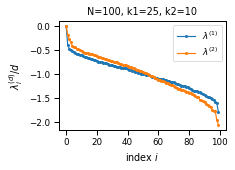

In [6]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(np.sort(lyap_1)[::-1], 'o-', ms=2, label=r'$\lambda^{(1)}$')
ax.plot(np.sort(lyap_2)[::-1]/2, 'o-', ms=2,  label=r'$\lambda^{(2)}$')

# ax.plot(lyap_1 + lyap_2, 'o-', ms=2,  label=r'$\lambda^{(2)}$')

# ax.plot(np.sort(lyap_12)[::-1], 'ko-', ms=2,  label=r'$\lambda^{(tot)}$')

# ax.plot(np.sort(lyap_1)[::-1] + np.sort(lyap_2)[::-1], 'ro-', ms=2,  label=r'$\lambda^{(tot)}$')

lyap_s = np.sort(lyap_12)[::-1]

ax.legend()
ax.set_title(fr"N={N}, k1={k1}, k2={k2}") #s, $\lambda^{{tot}}_2$={lyap_s[1]:.2f}, $\lambda^{{tot}}_N$={lyap_s[-1]:.2f}")
ax.set_ylabel(r"$\lambda^{(d)}_i / d$") #Lyapunov exponents 
ax.set_xlabel(r"index $i$")

# plt.savefig(f"random_iac__N_{N}_p1_{p1}_p2_{p2}_spectrum_g1_{gamma_1:+}_g2_{gamma_2:+}_normed.png", dpi=300, bbox_inches="tight")
plt.savefig(f"random_iac__N_{N}_k1_{k1}_k2_{k2}_spectrum_g1_{gamma_1:+}_g2_{gamma_2:+}_normed.png", dpi=300, bbox_inches="tight")

plt.show()

## Loop over parameter values

In [7]:
def compute_hypergraph_and_eigenvalues(k1, k2, N) : 
    
    p1, p2 = get_p1_and_p2(k1, k2, N)
    print(f"p1={p1:.3f}, p2={p2:.3f}")

    G, triangles_list = generate_random_hypergraph(p1, p2, N)

    # compute Laplacians and eigenvalues

    L1, K1 = laplacian_of_order(d=1, d_simplices=list(G.edges), return_k=True)
    L2, K2 = laplacian_of_order(d=2, d_simplices=triangles_list, return_k=True)

    gamma_1 = 1
    gamma_2 = 1

    L12 = (gamma_1 / np.mean(K1)) * L1 + (gamma_2 / np.mean(K2)) * L2 #+ (gamma_3 / np.mean(K3)) * L3

    eival_1, _ = np.linalg.eig(L1)
    eival_2, _ = np.linalg.eig(L2)

    eival_12, _ = np.linalg.eig(L12)

    lyap_1 = - (gamma_1 / np.mean(K1)) * eival_1
    lyap_2 = - (gamma_2 / np.mean(K2)) * eival_2

    lyap_12 = - eival_12
    
    return lyap_1, lyap_2, lyap_12

p1=0.063, p2=0.002
p1=0.253, p2=0.002


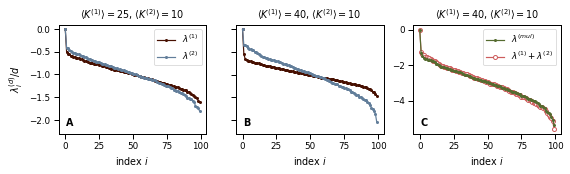

In [8]:
N = 100 # number of nodes in the hypergraph

ks = [(25, 10), (40, 10)]
n_k = len(ks)

fig, axs = plt.subplots(ncols=n_k+1, figsize=(3*(n_k+1), 2), sharey=False)


# plt.savefig(f"random_iac__N_{N}_p1_{p1}_p2_{p2}_spectrum_g1_{gamma_1:+}_g2_{gamma_2:+}_normed.png", dpi=300, bbox_inches="tight")
# plt.savefig(f"random_iac__N_{N}_k1_{k1}_k2_{k2}_spectrum_g1_{gamma_1:+}_g2_{gamma_2:+}_normed.png", dpi=300, bbox_inches="tight")

colors = ['#471001', '#627E9A']

for i, (k1, k2) in enumerate(ks) : 
    
    ax = axs[i]
    
    lyap_1, lyap_2, lyap_12 = compute_hypergraph_and_eigenvalues(k1, k2, N)
    
    ax.plot(np.sort(lyap_1)[::-1], 'o-', c=colors[0], ms=2, label=r'$\lambda^{(1)}$')
    ax.plot(np.sort(lyap_2)[::-1]/2, 'o-', c=colors[1], ms=2,  label=r'$\lambda^{(2)}$')
    lyap_s = np.sort(lyap_12)[::-1]
    
    ax.set_title(fr"$\langle K^{{(1)}} \rangle=${k1}, $\langle K^{{(2)}} \rangle=${k2}") #s, $\lambda^{{tot}}_2$={lyap_s[1]:.2f}, $\lambda^{{tot}}_N$={lyap_s[-1]:.2f}")
    ax.set_xlabel(r"index $i$")
    
axs[-1].plot(lyap_s, 'o-', c="darkolivegreen", ms=2, label=r'$\lambda^{(mul)}$')
color = 'indianred'
axs[-1].plot(np.sort(lyap_1)[::-1] + np.sort(lyap_2)[::-1], 'o-', c=color, mec=color, mfc='white', ms=4, zorder=-2, label=r'$\lambda^{(1)} + \lambda^{(2)}$')
axs[-1].legend()   
axs[-1].set_xlabel(r"index $i$")
axs[-1].set_title(fr"$\langle K^{{(1)}} \rangle=${k1}, $\langle K^{{(2)}} \rangle=${k2}") #s, $\lambda^{{tot}}_2$={lyap_s[1]:.2f}, $\lambda^{{tot}}_N$={lyap_s[-1]:.2f}")

axs[0].set_ylabel(r"$\lambda^{(d)}_i / d$") #Lyapunov exponents 
axs[0].legend()        

axs[0].set_ylim(ymin=-2.3)
axs[1].set_ylim(ymin=-2.3)
axs[1].set_yticklabels([])

for i, label in enumerate(('A', 'B', 'C')):
#     ax = fig.add_subplot(2,2,i+1)
    axs[i].text(0.05, 0.05, label, transform=axs[i].transAxes, fontweight='bold', va='bottom', ha='left')

plt.savefig(f"random_hypergraph_lyaps_N_{N}_ks_{ks}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"random_hypergraph_lyaps_N_{N}_ks_{ks}.pdf", dpi=250, bbox_inches="tight")

plt.show()
